In [140]:
# Import Libraries
import pandas as pd
import numpy as np
import xlsxwriter
import matplotlib.pyplot as plt
import csv

#show plot in notebook
%matplotlib inline 

#limits amount of lines pandas prints out
from pandas import set_option 
set_option('display.max_rows', 100)

# Importing and Cleaning Data

In [141]:
#Loading the main dataset from excel into python, specified taking data from the 'Sales' sheet
Sales_df = pd.read_excel('../data/Sales Data11.xlsm', sheetname = 'Sales')
Sales_df.head()
# Renaming the columns 
Sales_df.columns = [['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']]
Sales_df.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning
0,NaN,ABB Australia,engine technology,2010-08-04,1897.60,NaN,Returning
1,NaN,A&A Metal Products,engine technology,2010-08-16,28963.00,NaN,Returning
2,NaN,Analytical Engineer.,engine technology,2010-08-20,76339.00,NaN,Returning
3,NaN,Bombardier Inc.,aerospace,2010-08-27,24318.92,NaN,New
4,NaN,Beef Products Inc.,food,2010-09-15,35084.00,NaN,New


In [142]:
# Replacing the empty values in the Exchange Rate column with 1 and setting the index to Date_of_Order
Exchange_df= Sales_df[['Exchange_Rate', 'Customer', 'Field', 'Date_of_Order', 'Total_Sales', 'Year_of_First_Order', 'New_or_Returning']].replace([None], [1]).set_index('Date_of_Order')
# Creating a new column in the data set, which puts all sales amounts in Canadian dollars. 
Exchange_df['Sales_in_CAD'] = Exchange_df['Exchange_Rate'] * Exchange_df['Total_Sales']
Exchange_df.head()

,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
Date_of_Order,,,,,,,
2010-08-04,1,ABB Australia,engine technology,1897.60,1,Returning,1897.60
2010-08-16,1,A&A Metal Products,engine technology,28963.00,1,Returning,28963.00
2010-08-20,1,Analytical Engineer.,engine technology,76339.00,1,Returning,76339.00
2010-08-27,1,Bombardier Inc.,aerospace,24318.92,1,New,24318.92
2010-09-15,1,Beef Products Inc.,food,35084.00,1,New,35084.00


In [143]:
# Creating a new dataframe that includes all values with the Sales in CAD added
Change_New = Exchange_df[Exchange_df.index > '1980-01-01'].reset_index()
Change_New.head()

,Date_of_Order,Exchange_Rate,Customer,Field,Total_Sales,Year_of_First_Order,New_or_Returning,Sales_in_CAD
0,2010-08-04,1,ABB Australia,engine technology,1897.60,1,Returning,1897.60
1,2010-08-16,1,A&A Metal Products,engine technology,28963.00,1,Returning,28963.00
2,2010-08-20,1,Analytical Engineer.,engine technology,76339.00,1,Returning,76339.00
3,2010-08-27,1,Bombardier Inc.,aerospace,24318.92,1,New,24318.92
4,2010-09-15,1,Beef Products Inc.,food,35084.00,1,New,35084.00


The reason why the empty exchange rate values are replaced with 1 is because for these dates the exchange rate between Canadian and US dollars was basically 1, so the person entering the data did not bother writing in a value. 

# PLOT 1: Resampling data to make a plot that compares money spent on ads per month to sales coming from new customers & number of new customers.

I will first get rid of all rows that do not have a date, because this data is useless to me for making the first plot. I will modify the original dataframe. 

In [144]:
# Deleting all rows that do not have a value in the Date_of_Order column 
Dates_df = Sales_df[Sales_df.Date_of_Order.notnull()]
Dates_df.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning
0,NaN,ABB Australia,engine technology,2010-08-04,1897.60,NaN,Returning
1,NaN,A&A Metal Products,engine technology,2010-08-16,28963.00,NaN,Returning
2,NaN,Analytical Engineer.,engine technology,2010-08-20,76339.00,NaN,Returning
3,NaN,Bombardier Inc.,aerospace,2010-08-27,24318.92,NaN,New
4,NaN,Beef Products Inc.,food,2010-09-15,35084.00,NaN,New


In [145]:
# Deleting all rows of sales from returning customers
New_customers = Dates_df.groupby(['New_or_Returning']).get_group('New')
New_customers.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning
3,NaN,Bombardier Inc.,aerospace,2010-08-27,24318.92,NaN,New
4,NaN,Beef Products Inc.,food,2010-09-15,35084.00,NaN,New
5,NaN,Zhejiang Yuhong,other,2010-09-16,1563.00,NaN,New
6,NaN,UES Inc.,solutions provider,2010-09-16,1550.00,NaN,New
11,NaN,Nuance Systems Inc,solutions provider,2010-10-06,14357.60,NaN,New


In [146]:
# Grabbing 3 columns from the dataset and setting the index to Date of order.
Resampled_ind = New_customers[['Date_of_Order', 'Total_Sales', 'New_or_Returning']].set_index('Date_of_Order')
Resampled_ind.head()

,Total_Sales,New_or_Returning
Date_of_Order,,
2010-08-27,24318.92,New
2010-09-15,35084.00,New
2010-09-16,1563.00,New
2010-09-16,1550.00,New
2010-10-06,14357.60,New


In [147]:
# Replacing the 'New' string with the number 1 so that they can be added later. 
# And data is downsampled to month, taking the sum of the Sales and the new customers in each month. 
Index_Month= Resampled_ind[['New_or_Returning', 'Total_Sales']].replace(['New'], [1]).resample('M', how=('sum')) 
Index_Month.head()

,New_or_Returning,Total_Sales
Date_of_Order,,
2010-08-31,1,24318.92
2010-09-30,3,38197.00
2010-10-31,2,14967.60
2010-11-30,3,21461.66
2010-12-31,3,23468.45


In [148]:
# Deleting all rows that have a date before 2013-08-31. Keeping only two business years 2013 - 2015. The reason why I dont 
# want data before this date, is because the Date input in the dataset was incomplete for the previous years.
Downsampled_month = Index_Month[Index_Month.index > '2013-08-30']
Downsampled_month.head()

,New_or_Returning,Total_Sales
Date_of_Order,,
2013-08-31,3,7410.00
2013-09-30,4,13538.40
2013-10-31,5,9627.02
2013-11-30,10,40999.01
2013-12-31,5,35721.00


# Importing a new dataset (Cost of Ads per month)

In [149]:
#Loading another dataset from excel into python from a different sheet, and making the Date column the index.
Ads_df = pd.read_excel('../data/Sales Data11.xlsm', sheetname = 'Ads', index_col='Date')
Ads_df.head()

,Ad Cost
Date,
2013-08-01,947.94
2013-09-01,936.06
2013-10-01,935.72
2013-11-01,930.47
2013-12-01,948.00


In [150]:
# Renaming the column
# Resampling the date column, so that the month is synonymous with the other table 
Ads_df.columns = ['Ad_Cost']
Ads_df = Ads_df.resample('M', how=('sum'))   
Ads_df.head()

,Ad_Cost
Date,
2013-08-31,947.94
2013-09-30,936.06
2013-10-31,935.72
2013-11-30,930.47
2013-12-31,948.00


In [151]:
# Combining the two dataframes by the date of order, and resetting the index.
Combined_df = pd.concat([Downsampled_month, Ads_df], axis=1, join_axes=[Downsampled_month.index]).reset_index()
Combined_df.head()

,Date_of_Order,New_or_Returning,Total_Sales,Ad_Cost
0,2013-08-31,3,7410.00,947.94
1,2013-09-30,4,13538.40,936.06
2,2013-10-31,5,9627.02,935.72
3,2013-11-30,10,40999.01,930.47
4,2013-12-31,5,35721.00,948.00


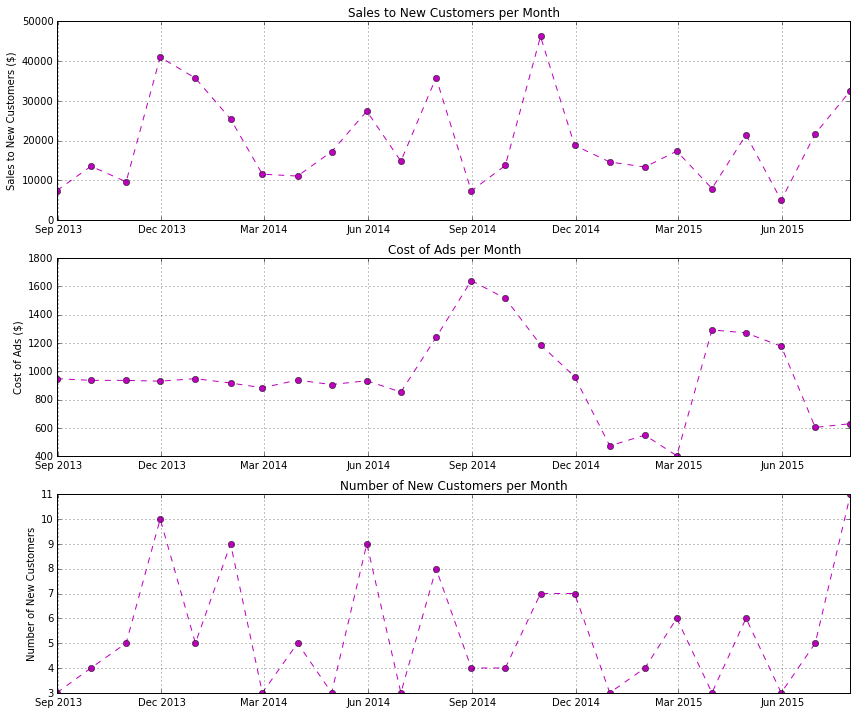

In [152]:
#change figure size
plt.figure(figsize=(12,10)) # in inches, width then height. 

#creating subplots and defining them
# 3 rows, 1 columns, 1st subplot
plt.subplot(3,1,1)      
plt.plot(Combined_df.Date_of_Order, Combined_df.Total_Sales, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales to New Customers per Month')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales to New Customers ($)')

# 3 rows, 1 columns, 2nd subplot
plt.subplot(3,1,2)      
plt.plot(Combined_df.Date_of_Order, Combined_df.Ad_Cost, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Cost of Ads per Month')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Cost of Ads ($)')

# 3 rows, 1 columns, 3rd subplot
plt.subplot(3,1,3)      
plt.plot(Combined_df.Date_of_Order, Combined_df.New_or_Returning, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Number of New Customers per Month')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Number of New Customers')

# give plots some breathing room
plt.tight_layout()

#show plot
plt.show()



#PLOT 2: Plotting the distribution of sales over the years 2013- 2015 by month (Instead of plotting Sales, could plot the number of customers too). 

In [153]:
# Visualizing the dataframe that we will downsample to make plot 2 
Dates_df.head()

,Exchange_Rate,Customer,Field,Date_of_Order,Total_Sales,Year_of_First_Order,New_or_Returning
0,NaN,ABB Australia,engine technology,2010-08-04,1897.60,NaN,Returning
1,NaN,A&A Metal Products,engine technology,2010-08-16,28963.00,NaN,Returning
2,NaN,Analytical Engineer.,engine technology,2010-08-20,76339.00,NaN,Returning
3,NaN,Bombardier Inc.,aerospace,2010-08-27,24318.92,NaN,New
4,NaN,Beef Products Inc.,food,2010-09-15,35084.00,NaN,New


In [154]:
# Grabbing 3 columns from a previous dataset and setting the index to Date of order
# Resampling the index column (Dates) by month, taking the sum of the Sales in each month.
Month_df = Change_New[['Date_of_Order', 'New_or_Returning', 'Sales_in_CAD']].set_index('Date_of_Order').resample('M', how=('sum')) 

In [155]:
# Deleting all rows before 2012-08-31. Keeping only 3 business years 2012 - 2015. 
df_less = Month_df[Index_Month.index > '2012-08-30']
df_less.head()

,Sales_in_CAD
Date_of_Order,
2012-08-31,266208.49
2012-09-30,242972.33
2012-10-31,78000.68
2012-11-30,165319.22
2012-12-31,8561.60


Making 3 different tables to have one table per business year from 2013-2015. Make a function for this so you dont have to repeat the same thing 3 times!

In [156]:
# Making a table for the business year 2014-2015 only
Year3_df = df_less.drop(df_less.index[:24]).reset_index()

#Creating a new column of month, by taking the month out of the Date_of_Order column  
Year3_df['Month'] = Year3_df['Date_of_Order'].dt.month
Year3_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2014-08-31,31362.196600,8
1,2014-09-30,139844.239100,9
2,2014-10-31,166207.229360,10
3,2014-11-30,66069.594558,11
4,2014-12-31,85777.469182,12


In [129]:
def month_name (df):
    '''Writes out the month number as a string'''
    with open (df, 'r') as mydf:
        if mydf['Month'] == 8 :
            return 'Aug'
        if mydf['Month'] == 9 :
            return 'Sep'
        if mydf['Month'] == 10 :
            return 'Oct'
        if mydf['Month'] == 11 :
            return 'Nov'
        if mydf['Month'] == 12 :
            return 'Dec' 
        if mydf['Month'] == 1 :
            return 'Jan' 
        if mydf['Month'] == 2 :
            return 'Feb' 
        if mydf['Month'] == 3 :
            return 'Mar' 
        if mydf['Month'] == 4 :
            return 'Apr' 
        if mydf['Month'] == 5 :
            return 'May' 
        if mydf['Month'] == 6 :
            return 'June' 
        if mydf['Month'] == 7 :
            return 'July'

In [128]:
month_name(Year3_df)

TypeError: 'delimiter' is an invalid keyword argument for this function

In [114]:
# Uses the function above to create a new column from the Year3_df dataframe. 
Year3 = Year3_df.apply(lambda row: month_name (row),axis=1)

In [118]:
#Combining the new column with month name with the Year3 column 
Combined_Month = pd.concat([Year3_df, Year3], axis=1, join_axes=[Year3.index]).reset_index()
Combined_Month.columns = [['index', 'Date_of_Order', 'Sales_in_CAD', 'Month', 'Month_str']]
Combined_Month.head()

,index,Date_of_Order,Sales_in_CAD,Month,Month_str
0,0,2014-08-31,31362.196600,8,Aug
1,1,2014-09-30,139844.239100,9,Sep
2,2,2014-10-31,166207.229360,10,Oct
3,3,2014-11-30,66069.594558,11,Nov
4,4,2014-12-31,85777.469182,12,Dec


In [107]:
# Making a table for the business year 2012-2013 only
Year1_df = df_less.drop(df_less.index[12:]).reset_index()

#Creating a new column of month, by taking the month out of the Date_of_Order column  
Year1_df['Month'] = Year1_df['Date_of_Order'].dt.month
Year1_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2012-08-31,266208.49,8
1,2012-09-30,242972.33,9
2,2012-10-31,78000.68,10
3,2012-11-30,165319.22,11
4,2012-12-31,8561.60,12


In [111]:
Year1 = Year1_df.apply(lambda row: month_name (row),axis=1)
#Combining the new column with month name with the Year3 column 
Combined_Month = pd.concat([Year1_df, Year1], axis=1, join_axes=[Year1.index]).reset_index()
Combined_Month.head()

,index,Date_of_Order,Sales_in_CAD,Month,0
0,0,2012-08-31,266208.49,8,Aug
1,1,2012-09-30,242972.33,9,Sep
2,2,2012-10-31,78000.68,10,Oct
3,3,2012-11-30,165319.22,11,Nov
4,4,2012-12-31,8561.60,12,Dec


In [109]:
# Making a table for the business year 2013-2014 only
Year2_df = df_less.iloc[12:24].reset_index()

#Creating a new column of month, by taking the month out of the Date_of_Order column  
Year2_df['Month'] = Year2_df['Date_of_Order'].dt.month
Year2_df.head()

,Date_of_Order,Sales_in_CAD,Month
0,2013-08-31,81819.96200,8
1,2013-09-30,58372.19460,9
2,2013-10-31,113018.98208,10
3,2013-11-30,104607.67808,11
4,2013-12-31,82281.35900,12


In [112]:
Year2 = Year2_df.apply(lambda row: month_name (row),axis=1)
#Combining the new column with month name with the Year3 column 
Combined_Month = pd.concat([Year2_df, Year2], axis=1, join_axes=[Year2.index]).reset_index()

Combined_Month.head()

,index,Date_of_Order,Sales_in_CAD,Month,0
0,0,2013-08-31,81819.96200,8,Aug
1,1,2013-09-30,58372.19460,9,Sep
2,2,2013-10-31,113018.98208,10,Oct
3,3,2013-11-30,104607.67808,11,Nov
4,4,2013-12-31,82281.35900,12,Dec


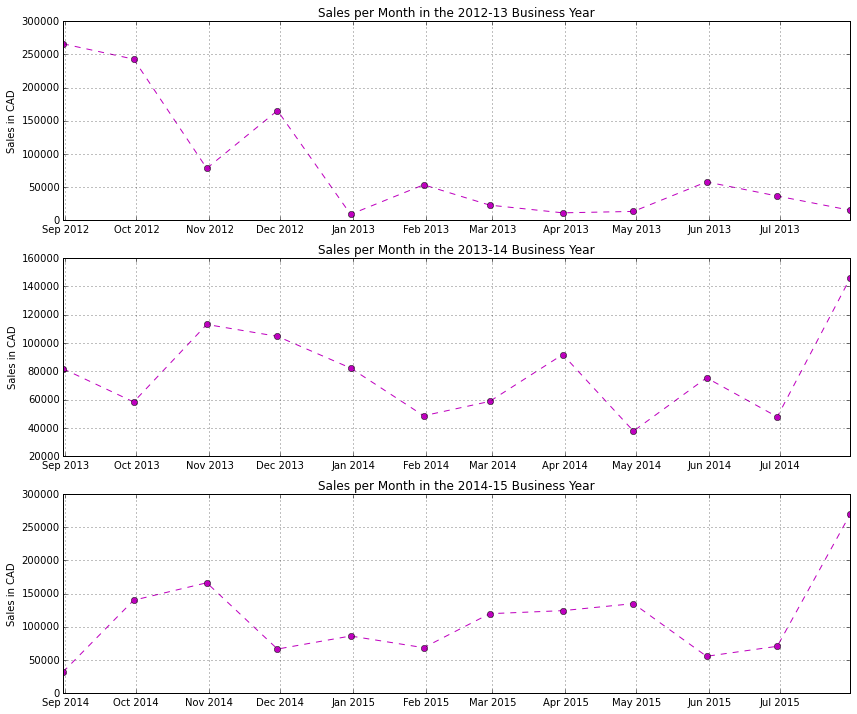

In [67]:
#change figure size
plt.figure(figsize=(12,10)) # in inches, width then height. 

#creating subplots and defining them
# 3 rows, 1 columns, 1st subplot
plt.subplot(3,1,1)      
plt.plot(Year1_df.Date_of_Order, Year1_df.Sales_in_CAD, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales per Month in the 2012-13 Business Year')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales in CAD')

# 3 rows, 1 columns, 2nd subplot
plt.subplot(3,1,2)      
plt.plot(Year2_df.Date_of_Order, Year2_df.Sales_in_CAD, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales per Month in the 2013-14 Business Year')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales in CAD')

# 3 rows, 1 columns, 3rd subplot
plt.subplot(3,1,3)      
plt.plot(Year3_df.Date_of_Order, Year3_df.Sales_in_CAD, marker='o', color ='m', linestyle='--')
#Add title
plt.title('Sales per Month in the 2014-15 Business Year')
#Add gridlines
plt.grid(True)
#Add axis labels
plt.ylabel('Sales in CAD')

# give plots some breathing room
plt.tight_layout()

#show plot
plt.show()

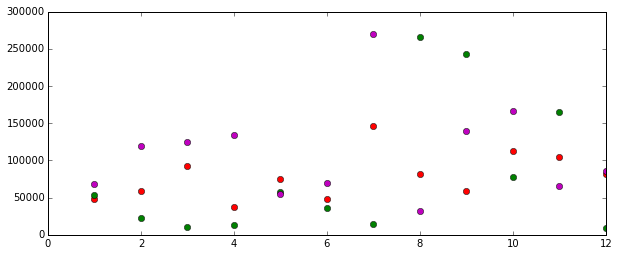

In [167]:
#Plotting all 3 subplots in the same plot as a scatter plot
plt.figure(figsize=(10,4))
plt.plot(Year2_df.Month, Year2_df.Sales_in_CAD, 'ro', Year2_df.Month, Year1_df.Sales_in_CAD, 'go', Year1_df.Month, Year3_df.Sales_in_CAD, 'mo')

#PLOT3: Creating a boxplot that shows the distribution of sales across all fields, also showing how large individual Sales were. This will be done for all years combined first. 

In [170]:
#Make groupby object which represents groups in the column Fields
#Group by some sort of category. In this case grouping by Field. 
resampled_groups = Exchange_df.groupby(['Field', 'Sales_in_CAD']).sum()
resampled_groups.head()

Exchange_Rate  Total_Sales
Field     Sales_in_CAD                            
aerospace 124.5840             1.0740          116
          235.5885             1.2465          189
          505.0000             1.0000          505
          559.7100             1.2438          450
          1410.1620            1.0740         1313

In [171]:
#Resetting the index to get ready to plot the data
resampled1_groups = resampled_groups.reset_index()
resampled1_groups.head()

,Field,Sales_in_CAD,Exchange_Rate,Total_Sales
0,aerospace,124.5840,1.0740,116
1,aerospace,235.5885,1.2465,189
2,aerospace,505.0000,1.0000,505
3,aerospace,559.7100,1.2438,450
4,aerospace,1410.1620,1.0740,1313


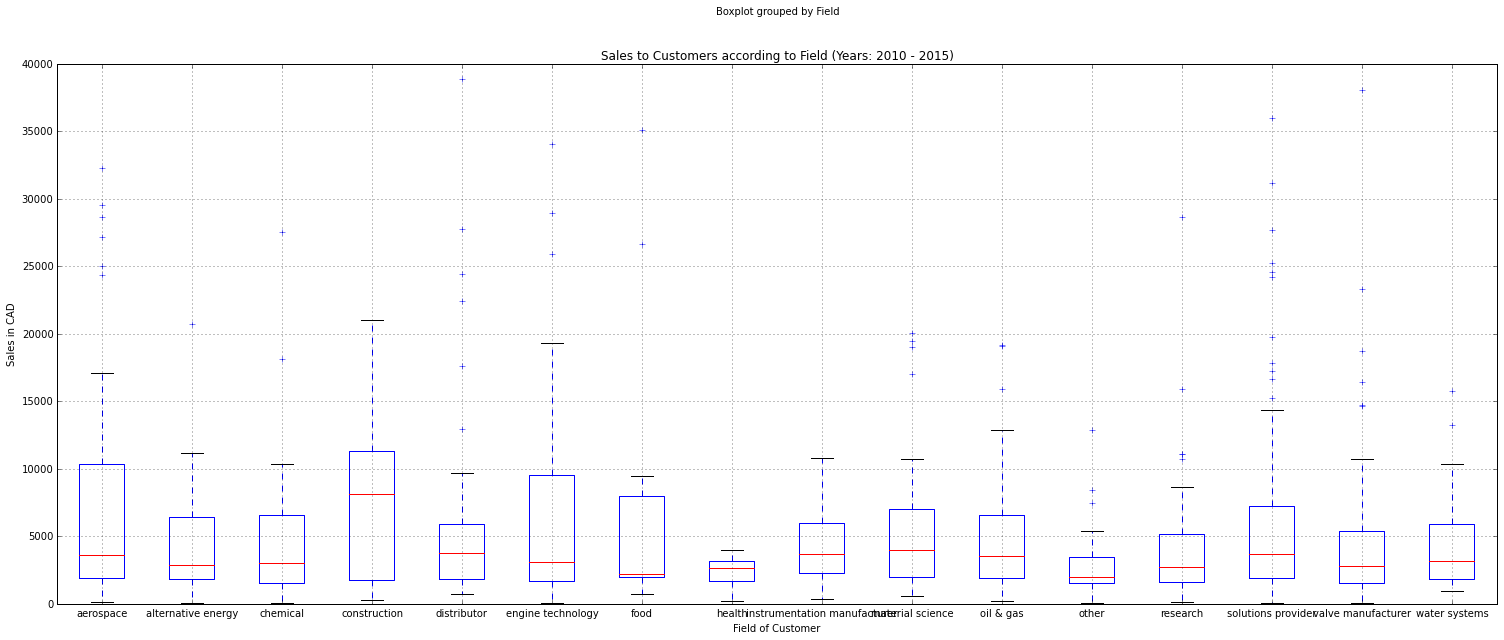

In [172]:
#Creating a boxplot of Sales according to the field a customer works in. This plot is for all years (2010 - 2015) combined
resampled1_groups.boxplot(by = 'Field', column='Sales_in_CAD', figsize=(25,10))

#Changing the y limit
plt.ylim(0, 40000)

plt.title('Sales to Customers according to Field (Years: 2010 - 2015)')
plt.xlabel('Field of Customer')
plt.ylabel('Sales in CAD')


For every year seperately


#PLOT4: Creating a plot that shows sales to returning customers vs. Sales to new customers, to help determine whether it is more important to invest money in ads to target new customers, or to maintain old customers. 

In [168]:
# Grabbing 2 columns from a previously cleaned data set (Change_New) 
Customers_df = Change_New[['Sales_in_CAD', 'New_or_Returning']]
Customers_df.head()

,Sales_in_CAD,New_or_Returning
0,1897.60,Returning
1,28963.00,Returning
2,76339.00,Returning
3,24318.92,New
4,35084.00,New


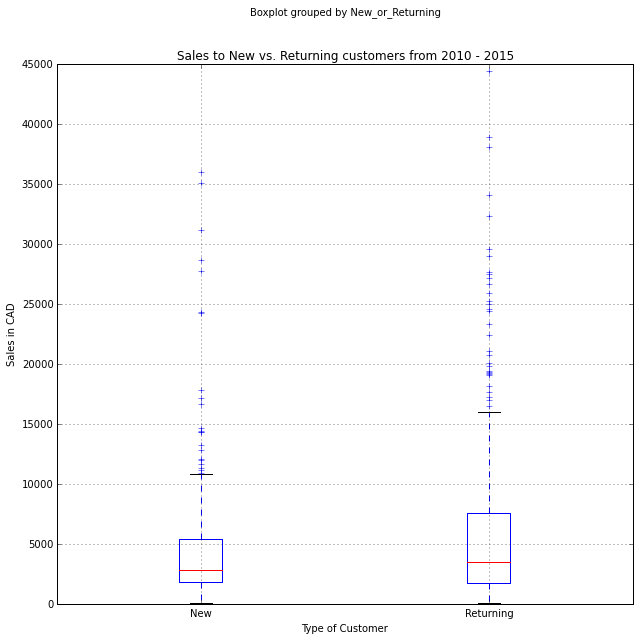

In [169]:
# Creating a boxplot of New versus Returning customer Sales.
Customers_df.boxplot(by = 'New_or_Returning', column='Sales_in_CAD', figsize=(10,10))
plt.ylim(0, 45000)
plt.title('Sales to New vs. Returning customers from 2010 - 2015')
plt.xlabel('Type of Customer')
plt.ylabel('Sales in CAD')
